# Preparing the environment

In [1]:
from algorithms import *
from casino import Casino
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from IPython.core.pylabtools import figsize

In [2]:
%load_ext autoreload
%autoreload 2

> **Note** :
> The experiments done in this notebook may not be **samely reproducible** as we do not specify a fixed seed for 
> `numpy.random`.

# Analyzing the UCB algorithm

- First let's create an instance of a `Casino`. It will have 10 machines each with a randomly generated payoff. These payoffs will be the same for all the following experiments, meaning only one instance of `Casino` will be used.
- Once this is done, we can create an instance of `UCB` that will use the created casino for the calculations and an initial cerdit of 1000.

In [12]:
nb_machines = 10
initial_credits = 1_000

casino = Casino(nb=nb_machines)
ucb = UCB(casino, initialCredits=initial_credits)

Let's get the best confidence value for the UCB. We can do that by trying different values of confidence between 0.1 and 1.0 each one multiple times, calculate the mean and draw the corresponding curve. We will repeat UCB on each confidence value 50 times before calculating the mean so that the value does not get biaised as the casino machines use probabilities to return rewards.

  0%|          | 0/450 [00:00<?, ?it/s]

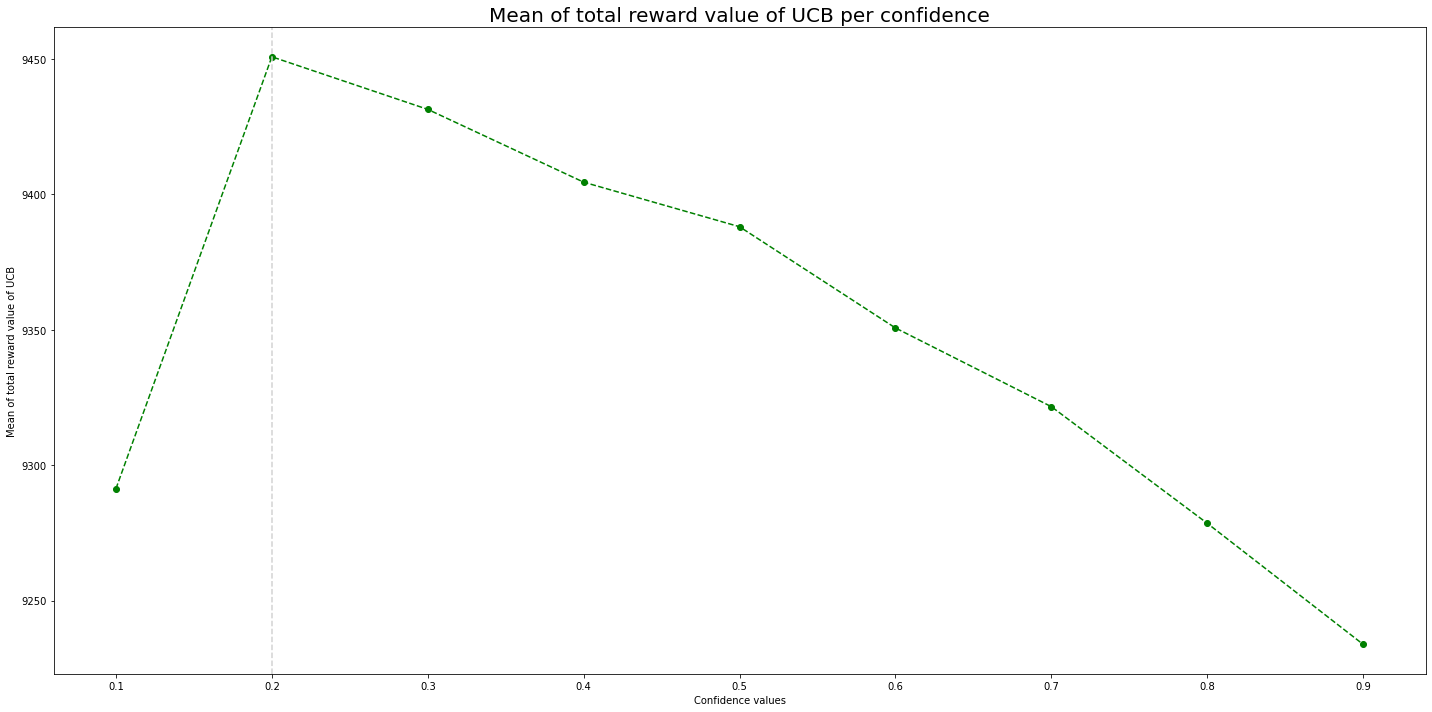

In [72]:
confidence_values = np.arange(0.1, 1.0, 0.1)
total_rewards = []
repetition = 50
with tqdm(total=len(confidence_values) * repetition) as pbar:
    for c in range(len(confidence_values)):
        reward = 0
        for i in range(repetition):
            reward += ucb.do_ucb(confidence_values[c])
            ucb.initialize()
            pbar.update(1)
        total_rewards.append(reward / repetition)


fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Mean of total reward value of UCB")
ax.set_xlabel("Confidence values")
ax.set_title("Mean of total reward value of UCB per confidence", fontsize=20)
plt.plot(confidence_values, total_rewards, marker="o", linestyle="--", color="g")
ax.axvline(
    x=confidence_values[np.argmax(total_rewards)], linestyle="--", color="lightgrey"
)
fig.tight_layout()

The curve shows the value of confidence that gave the maximum mean total reward is 0.2. We will be using this value from now on.

In [13]:
confidence = 0.2

In [15]:
# UCB rewards and UCB cumulative rewards
ucb_rewards = []
time_steps = range(initial_credits)
ucb.initialize()
reward, _ = ucb.do_one_step_ucb(confidence)
while reward is not None:
    ucb_rewards.append(reward)
    reward, _ = ucb.do_one_step_ucb(confidence)
cumulative_ucb_rewards = np.cumsum(ucb_rewards)

# Optimal rewards and cumulative optimal rewards
optimal_rewards = [casino.real_best_choice().play() for _ in range(initial_credits)]
cumulative_optimal_rewards = np.cumsum(optimal_rewards)

In [20]:
# Mean UCB rewards per time
episodes = 1000
ucb_rewards_2 = np.zeros((episodes, initial_credits))
for episode in tqdm(range(episodes), desc="Mean UCB rewards per time"):
    ucb.initialize()
    reward, time_step = ucb.do_one_step_ucb(confidence)
    while reward is not None:
        ucb_rewards_2[episode, time_step] = reward
        reward, time_step = ucb.do_one_step_ucb(confidence)

mean_ucb_rewards = ucb_rewards_2.mean(axis=0)

Mean UCB rewards per time:   0%|          | 0/10000 [00:00<?, ?it/s]

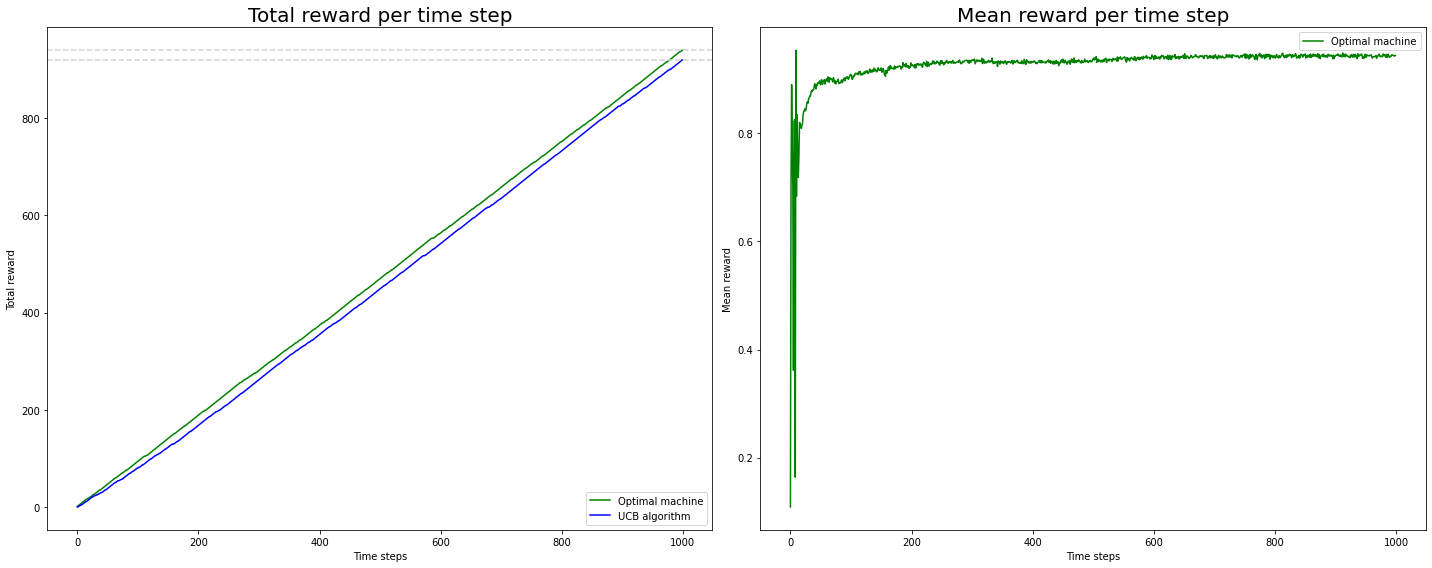

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(time_steps, cumulative_optimal_rewards, color="g", label="Optimal machine")
ax1.plot(time_steps, cumulative_ucb_rewards, color="b", label="UCB algorithm")
ax1.axhline(y=np.max(cumulative_ucb_rewards), linestyle="--", color="lightgrey")
ax1.axhline(y=np.max(cumulative_optimal_rewards), linestyle="--", color="lightgrey")

ax1.set_ylabel("Total reward")
ax1.set_xlabel("Time steps")
ax1.set_title("Total reward per time step", fontsize=20)
ax1.legend()


ax2.plot(time_steps, mean_ucb_rewards, color="g", label="Optimal machine")
# ax2.plot(time_steps, ucb_rewards, color="b", label="UCB algorithm")

ax2.set_ylabel("Mean reward")
ax2.set_xlabel("Time steps")
ax2.set_title("Mean reward per time step", fontsize=20)
ax2.legend()

fig.tight_layout()

In [ ]:
ucb_rewards = np.zeros(iters)

episodes = 1000

for i in range(episodes):
    ucb.reset("random")
    # Run experiments
    ucb.run()

    # Update long-term averages
    ucb_rewards = ucb_rewards + (ucb.reward - ucb_rewards) / (i + 1)

    # Mean UCB rewards per time
episodes = 10000
ucb_rewards_2 = np.zeros((episodes, initial_credits))
for episode in tqdm(range(episodes), desc="Mean UCB rewards per time"):
    ucb.initialize()
    reward, time_step = ucb.do_one_step_ucb(confidence)
    while reward is not None:
        ucb_rewards_2[episode, time_step] = reward
        reward, time_step = ucb.do_one_step_ucb(confidence)

mean_ucb_rewards = ucb_rewards_2.mean(axis=0)

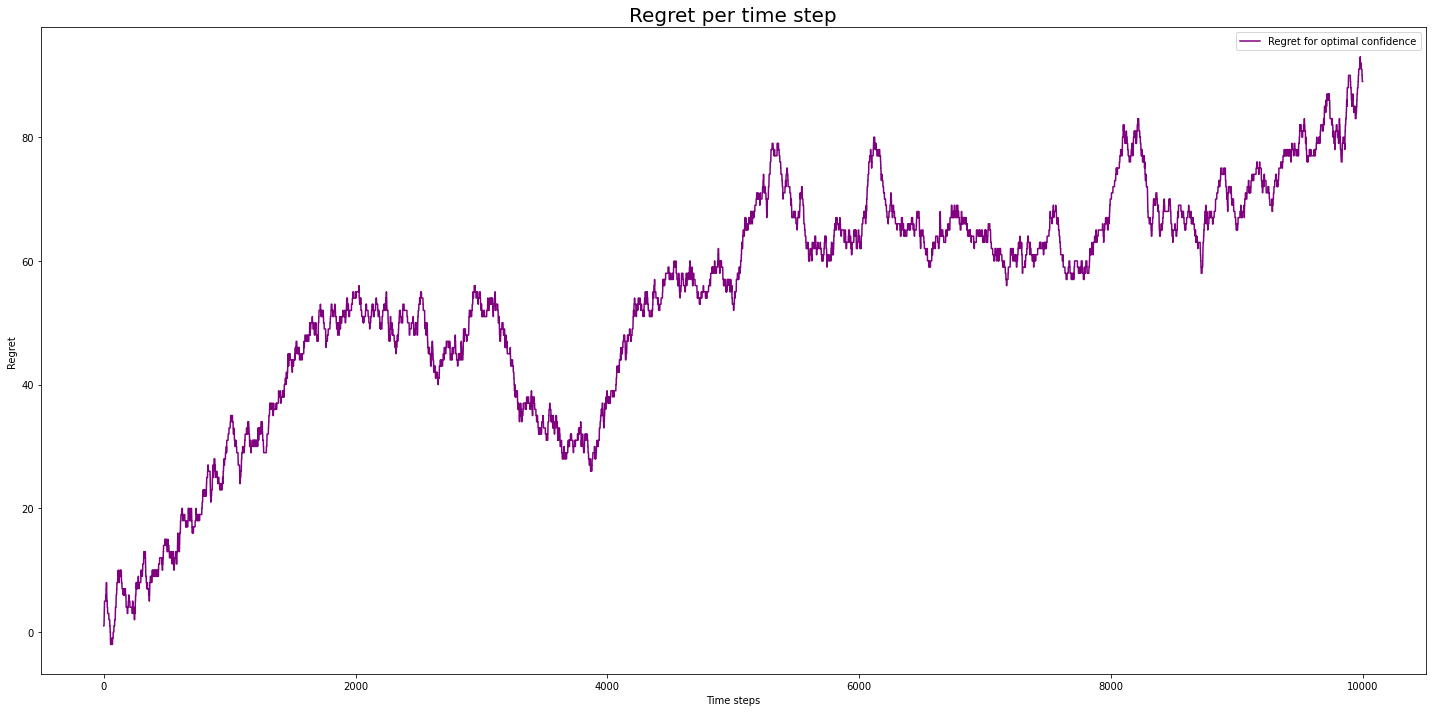

In [52]:
regret_1 = cumulative_optimal_rewards_per_time - cumulative_ucb_rewards_per_time
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel("Regret")
ax.set_xlabel("Time steps")
ax.set_title("Regret per time step", fontsize=20)
plt.plot(time_steps, regret_1, color="purple", label="Regret for optimal confidence")

ax.legend()
fig.tight_layout()

# Improving the UCB algorithm

The mehtod is inspired by the work in [this paper](http://personal.unileoben.ac.at/rortner/Pubs/UCBRev.pdf).